In [1]:
import scarches as sca
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import pandas as pd
import os
import sys
import importlib

Using TensorFlow backend.


In [2]:
sys.path.insert(0, "../lib")

In [3]:
import sc_utils

In [4]:
pd.set_option('display.max_rows', 1000)

In [66]:
mpl.rcParams["figure.figsize"] = (12, 12)

## Load latent and combined datasets

In [67]:
latent = sc.read_h5ad("../data/03ipf_projection/01latent2.h5ad")

In [68]:
combined = sc.read_h5ad("../data/03ipf_projection/01combined.h5ad")

## Focus only on Epithelial cells

In [69]:
latent.obs.population.value_counts()

Immune-TX         76534
Immune            61393
Epithelial        37325
Epithelial-TX     32416
Stromal-TX        31032
Endothelial-TX    15431
Endothelial       10446
Mesenchymal        5232
Name: population, dtype: int64

In [70]:
latent = latent[latent.obs.population.isin(["Epithelial", "Epithelial-TX"]), ]
epi = combined[combined.obs.population.isin(["Epithelial", "Epithelial-TX"]), ]

In [71]:
latent.shape

(69741, 10)

In [72]:
epi.shape

(69741, 19202)

## Cluster on latent space and transfer to expression object

In [73]:
sc.tl.leiden(latent, resolution=0.2)

Trying to set attribute `.obs` of view, copying.


In [74]:
epi.obs["leiden"] = latent.obs.leiden

Trying to set attribute `.obs` of view, copying.


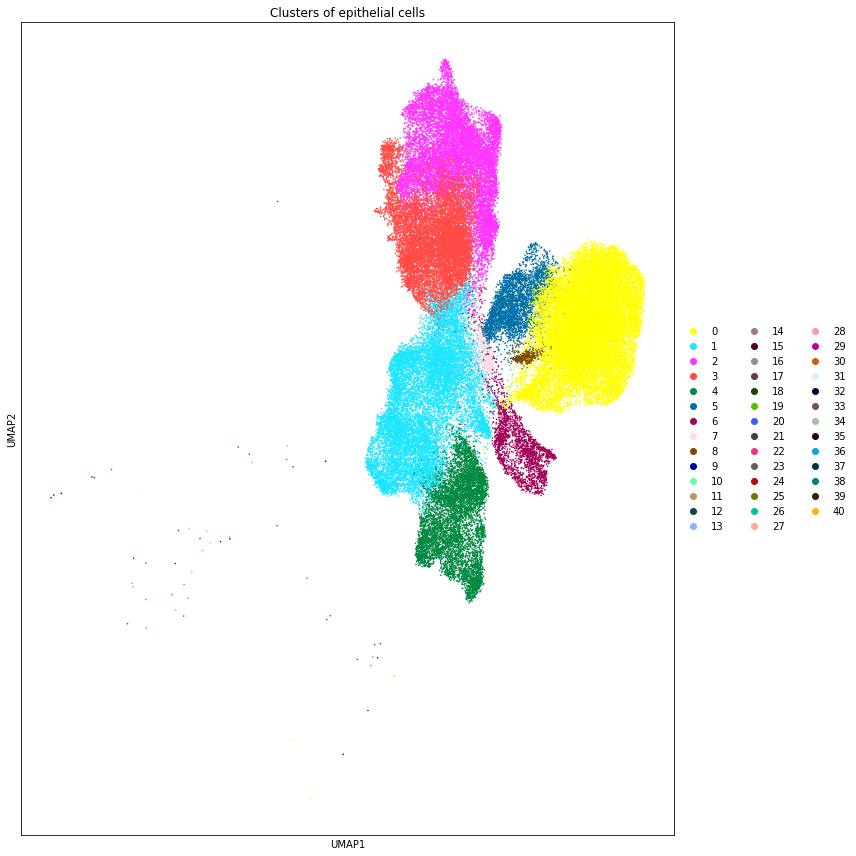

In [75]:
ax = sc.pl.umap(
    epi, 
    color="leiden",
    size=10, 
    title="Clusters of epithelial cells",
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()

There are many small clusters comprised of just 1, 2 or 3 cells. Let's remove them and recluster.

In [76]:
leiden_size = epi.obs.leiden.value_counts()

In [77]:
leiden_size

0     19649
1     13330
2     12124
3     10991
4      6902
5      3327
6      2190
7       807
8       379
10        3
9         3
11        2
12        2
13        2
14        2
15        2
16        2
19        1
17        1
18        1
40        1
39        1
21        1
38        1
37        1
36        1
35        1
34        1
33        1
32        1
31        1
30        1
29        1
28        1
27        1
26        1
25        1
24        1
23        1
22        1
20        1
Name: leiden, dtype: int64

In [78]:
latent = latent[~latent.obs.leiden.isin(leiden_size.index[leiden_size <= 3]), :]
epi = epi[~epi.obs.leiden.isin(leiden_size.index[leiden_size <= 3]), :]

In [80]:
sc.tl.leiden(latent, resolution=0.5)

Trying to set attribute `.obs` of view, copying.


In [81]:
epi.obs["leiden"] = latent.obs.leiden

Trying to set attribute `.obs` of view, copying.


In [82]:
latent.obs.leiden.value_counts()

0     17046
1     10087
2      7177
3      5335
4      5138
5      4970
6      4853
7      4220
8      2636
9      2202
10     1976
11     1947
12     1713
13      399
Name: leiden, dtype: int64

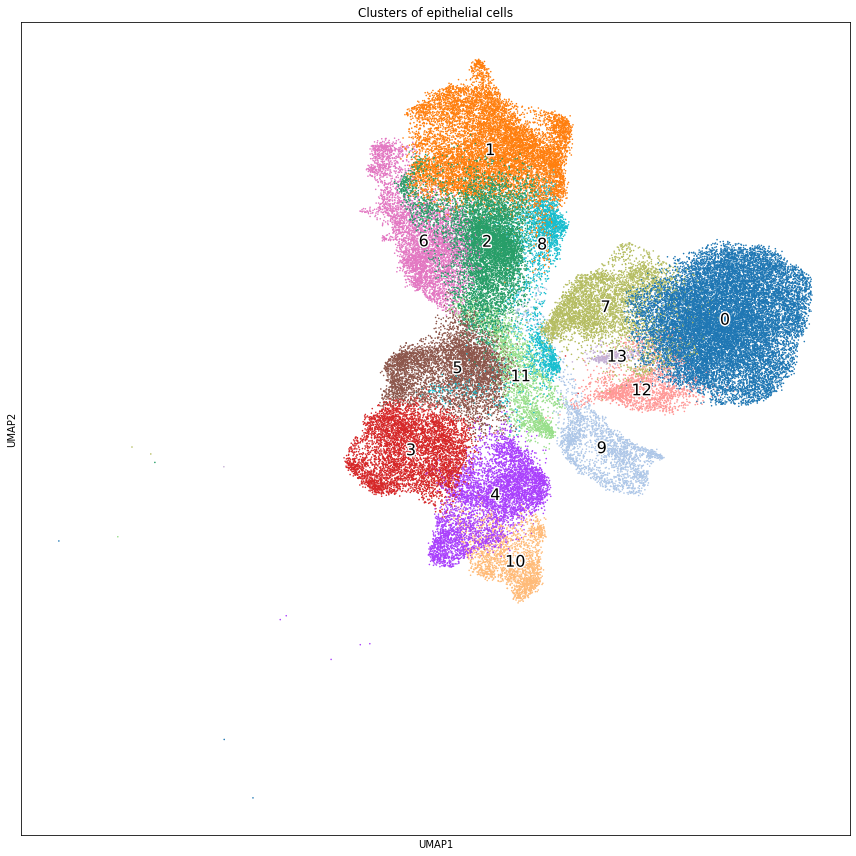

In [83]:
ax = sc.pl.umap(
    epi, 
    color="leiden",
    size=10, 
    title="Clusters of epithelial cells",
    legend_loc="on data",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()

How cell type annotations from Habermann and Bharat separate analyses contribute to different clusters derived from the latent space?

<AxesSubplot:title={'center':'Leiden by celltype'}>

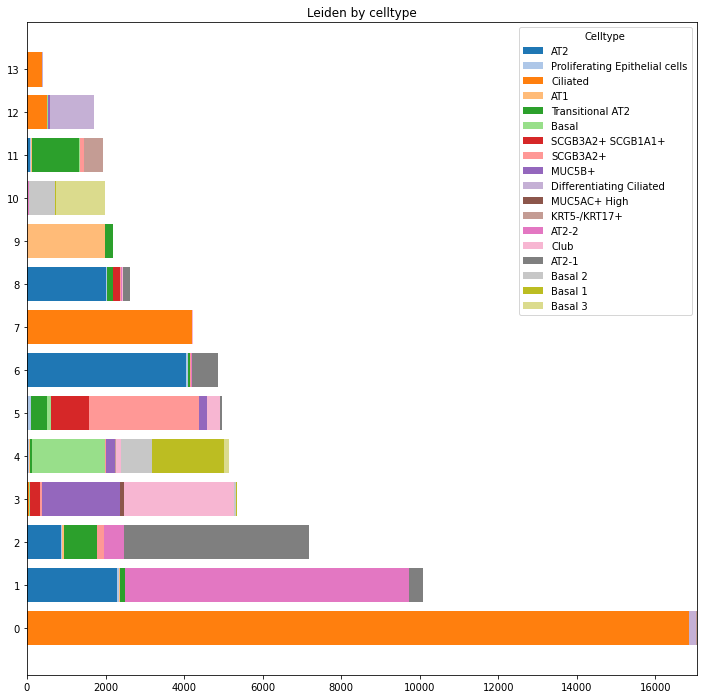

In [84]:
sc_utils.plot_composition(epi, "leiden", "celltype")

And Diagnosis?

In [85]:
epi.obs.Diagnosis.value_counts()

IPF             24877
COVID-19        16768
Control (B.)    15637
Control (H.)     8425
Other PF         3992
Name: Diagnosis, dtype: int64

<AxesSubplot:title={'center':'Leiden by Diagnosis'}>

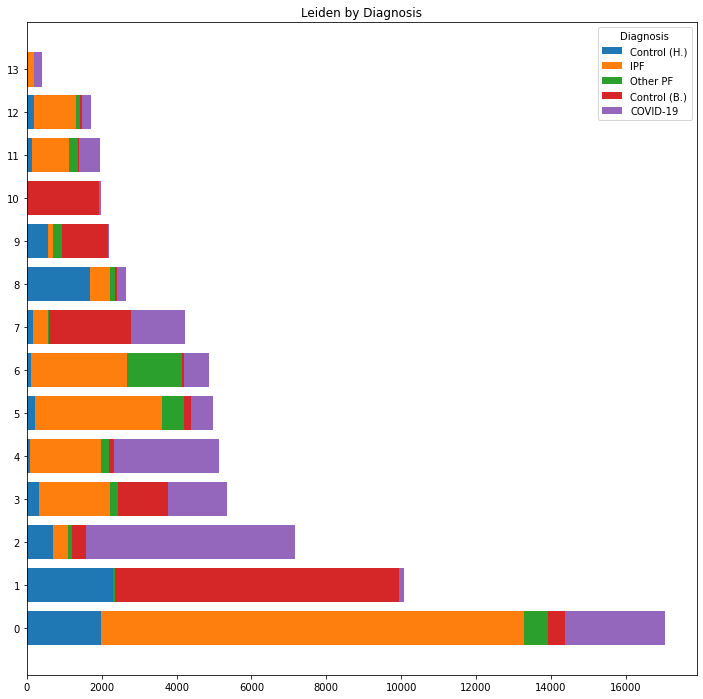

In [86]:
sc_utils.plot_composition(epi, "leiden", "Diagnosis")

In [ ]:
cl11_samples = epi.obs.Sample_Name.loc[
    (epi.obs.leiden == "11")
].value_counts()
cl11_samples / cl11_samples.sum() * 100

In [88]:
epi.raw = epi

In [28]:
sc.tl.rank_genes_groups(epi, "leiden", method="wilcoxon", n_genes=100)
markers = sc_utils.get_markers(epi, "leiden")

In [29]:
markers.cluster = markers.cluster.astype(int)

In [30]:
markers.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[True, False])

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
0,0.000000e+00,6.514215,0.997360,0.126109,0.000000e+00,0,C20orf85
1,0.000000e+00,6.248783,0.994134,0.122652,0.000000e+00,0,C9orf24
3,0.000000e+00,5.936318,0.987328,0.104154,0.000000e+00,0,C1orf194
5,0.000000e+00,5.925209,0.982107,0.104704,0.000000e+00,0,SNTN
4,0.000000e+00,5.911851,0.986859,0.113498,0.000000e+00,0,FAM183A
43,0.000000e+00,5.866633,0.890121,0.068980,0.000000e+00,0,C2orf40
21,0.000000e+00,5.718333,0.973777,0.127628,0.000000e+00,0,TMEM190
15,0.000000e+00,5.668910,0.963511,0.096500,0.000000e+00,0,DYNLRB2
9,0.000000e+00,5.574898,0.990203,0.137827,0.000000e+00,0,RSPH1
13,0.000000e+00,5.553412,0.973190,0.118056,0.000000e+00,0,C9orf116


In [35]:
epi.obs.leiden = epi.obs.leiden.astype("category")

In [36]:
epi.write_h5ad("../data/03ipf_projection/02epi.h5ad")

In [32]:
markers.to_csv("../data/03ipf_projection/02epi-markers.csv")

In [5]:
epi = sc.read_h5ad("../data/03ipf_projection/02epi.h5ad")

Merge:

4 and 10 - basal, genes to show KRT5, KRT17, TP63, WNT10A (fun fact: cluster 4 contains FOXI1 ionocytes, but because projecting onto Habermann - they did not get resolved and ended up in basal cell cluster)

keep 3 - secretory-1, genes to show MUC5B, MUC5AC, BPIFA1, BPIFB1

keep 5 - secretory-2, genes to show ANPEP, SCGB3A2, MGP

1, 2, 6, 8 - AT2, Genes to show SFTPC, SFTPA1, LAMP3

0, 7, 13 - ciliated TPPP3, FOXJ1, DYNLRB2

keep 12 - differentiating ciliated, no need to plot separate genes, they will be resolved.

keep 9 - AT1, genes to show: AGER, RTKN2, SPOCK2

keep 11, KRT17+KRT5-, genes to show: FN1, COL1A1, CCND2, CDKN2A.

In [226]:
epi.obs["cluster"] = epi.obs.leiden.copy()

In [227]:
epi.obs.loc[epi.obs.cluster.isin(["10"]), "cluster"] = "4"
epi.obs.loc[epi.obs.cluster.isin(["7", "13"]), "cluster"] = "0"
epi.obs.loc[epi.obs.cluster.isin(["2", "6", "8"]), "cluster"] = "1"

In [228]:
epi.obs.cluster = epi.obs.cluster.astype("str")
epi.obs.cluster.replace({
    "0": "1",
    "1": "2",
    "9": "6",
    "11": "7",
    "12": "8"
}, inplace=True)
# 4 will become 1, 3>2, 5>3, 8>4, 1>5, 2>6, 7>7, 6>8
epi.obs.cluster.replace({
    "4": "1",
    "3": "2",
    "5": "3",
    "8": "4",
    "1": "5",
    "2": "6",
    "6": "8"
}, inplace=True)
epi.obs.cluster = epi.obs.cluster.astype("category")

... storing 'heatmap' as categorical


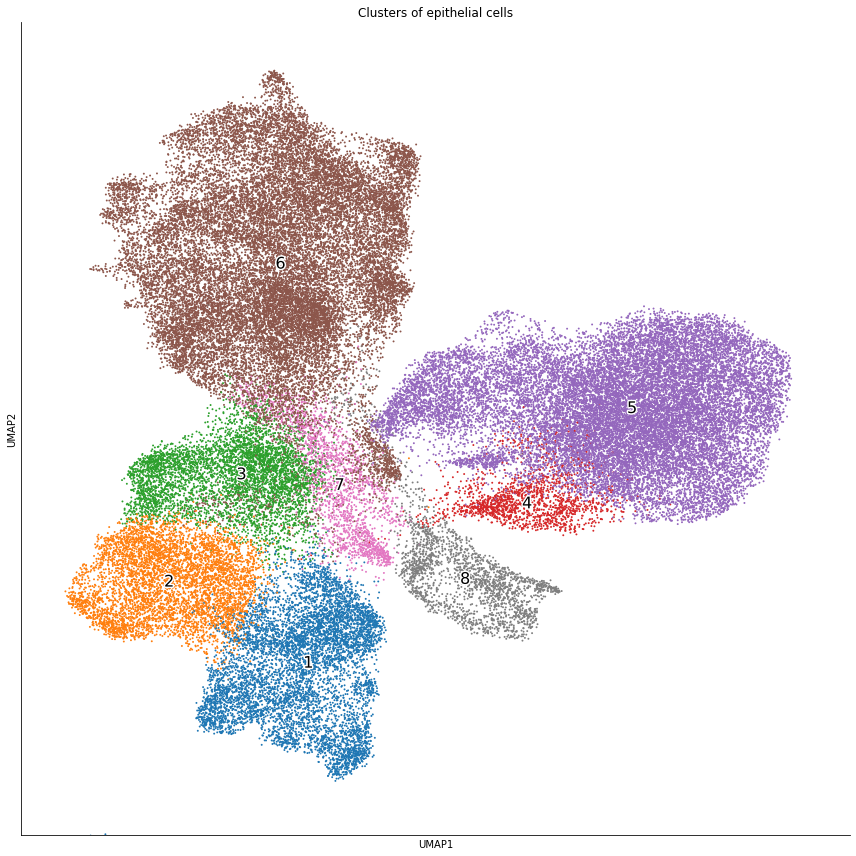

In [229]:
ax = sc.pl.umap(
    epi, 
    color="cluster",
    size=15, 
    frameon=True,
    title="Clusters of epithelial cells",
    legend_loc="on data",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.xaxis.set_visible(True)
# ax.xaxis.reset_ticks()
# ax.set_axis_on()
# ax.tick_params(reset=True)
# ax.set_yticks([0, 5, 10, 15])
# ax.set_xticks([0, 5, 10, 15])
ax.set_ylim(bottom=-1)
ax.set_xlim(left=7)
ax.figure.tight_layout()
ax.figure.savefig("02epi-clusters.pdf")

In [230]:
epi.obs.Diagnosis = epi.obs.Diagnosis.cat.reorder_categories(
    ["Control (H.)", "Control (B.)", "COVID-19", "IPF", "Other PF"]
)

In [231]:
cat_palette = list(mpl.cm.tab10.colors)
cat_palette[0], cat_palette[2] = cat_palette[2], cat_palette[0]
cat_palette[2], cat_palette[3] = cat_palette[3], cat_palette[2]

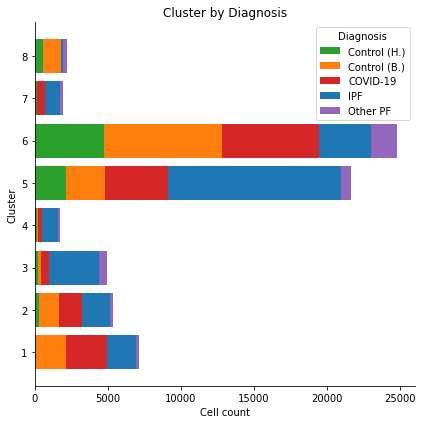

In [232]:
ax = sc_utils.plot_composition(epi, "cluster", "Diagnosis", palette=cat_palette)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.figure.set_size_inches((6, 6))
ax.set_ylabel("Cluster")
ax.set_xlabel("Cell count")
ax.figure.tight_layout()
ax.figure.savefig("02epi-composition.pdf")

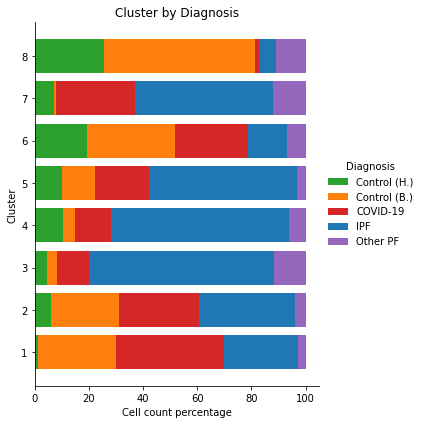

In [233]:
ax = sc_utils.plot_composition(epi, "cluster", "Diagnosis", relative=True, palette=cat_palette)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.figure.set_size_inches((6, 6))
ax.set_ylabel("Cluster")
ax.set_xlabel("Cell count percentage")
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="Diagnosis")
ax.figure.tight_layout()
ax.figure.savefig("02epi-composition-rel.pdf")

## Genes heatmap

In [235]:
# heatmap group
#epi.obs["hm_group"] = epi.obs.P
epi.obs["hm_group"] = epi.obs.Diagnosis.copy()
epi.obs.hm_group = epi.obs.hm_group.astype("str")
epi.obs.loc[epi.obs.Sample_Source == "NU", "hm_group"] = epi.obs.Sample_Name.loc[epi.obs.Sample_Source == "NU"]
epi.obs.hm_group = epi.obs.hm_group.astype("category")
epi.obs.hm_group = epi.obs.hm_group.cat.reorder_categories([
    "Control (H.)", "Donor 1", "Donor 2",
    "Other PF", "IPF", "Case 1", "PMB 1", "PMB 2"
])
epi.obs.hm_group.value_counts()

IPF             24877
Donor 1         10574
Control (H.)     8425
PMB 1            7565
Donor 2          5063
PMB 2            4779
Case 1           4424
Other PF         3992
Name: hm_group, dtype: int64

In [236]:
epi.obs["heatmap"] = epi.obs.cluster.astype(str) + "," + epi.obs.hm_group.astype(str)

In [259]:
genes_of_i = """KRT5
KRT17
TP63
WNT10A
MUC5B
MUC5AC
BPIFA1
BPIFB1
ANPEP
SCGB3A2
MGP
TPPP3
FOXJ1
DYNLRB2
SFTPC
SFTPA1
LAMP3
FN1
COL1A1
CCND2
CDKN2A
AGER
RTKN2
SPOCK2""".split("\n")

In [260]:
markers_expr = []
clusters = list(epi.obs.heatmap.astype(str).unique())
clusters.sort(key=lambda x: (x.split(",")[0], epi.obs.hm_group.cat.categories.get_loc(x.split(",")[1])))
for g in clusters:
    mean_exp = epi.raw.X[(epi.obs.heatmap == g).values, :][:, epi.var_names.isin(genes_of_i)].mean(axis=0).A.reshape(-1)
    markers_expr.append(mean_exp)

In [261]:
markers_expr = pd.DataFrame(markers_expr, columns=epi.var_names[epi.var_names.isin(genes_of_i)], index=clusters)

In [262]:
markers_expr = (markers_expr - markers_expr.min()) / markers_expr.max()

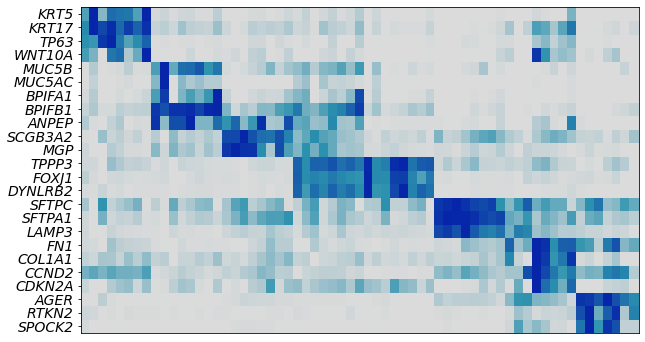

In [263]:
fig, ax = plt.subplots(
    figsize=(10, 6)
)
ax.pcolormesh(markers_expr.loc[:, reversed(genes_of_i)].T.to_numpy(), cmap=sc_utils.expr_colormap())
ax.set_yticks(pd.Series(range(len(genes_of_i))) + 0.5)
ax.set_yticklabels(
    reversed(genes_of_i),
    fontstyle="italic",
    fontsize=14
)
ax.tick_params(bottom=False, labelbottom=False)

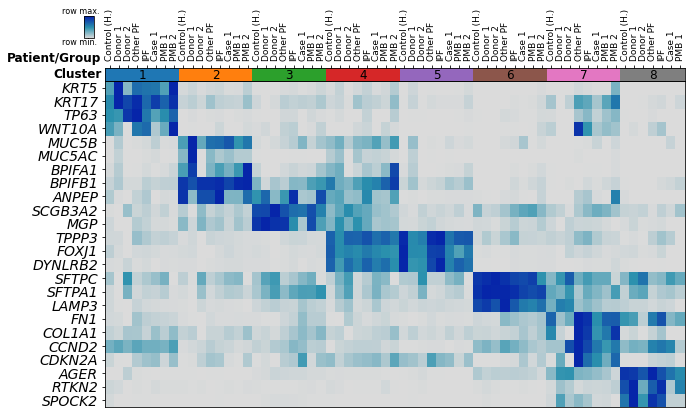

In [264]:
ax0bbox = ax.get_position()
labs = fig.add_axes((ax0bbox.x0, ax0bbox.y1, ax0bbox.width, 0.03), sharex=ax)
labs.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=True, labeltop=True)
clusters = pd.Series(markers_expr.index.str.split(",")).apply(lambda x: x[0]).value_counts().sort_index()
pats = pd.Series(markers_expr.index.str.split(",")).apply(lambda x: x[1])
s = 0
for i, n in enumerate(clusters.index):
    w = clusters[n]
    labs.add_patch(mpl.patches.Rectangle(
        (s, 0), 
        w, 
        1, 
        facecolor=mpl.cm.tab10(i)
    ))
    labs.annotate(
        n, 
        (w / 2 + s, 0.45),
        ha="center",
        va="center",
        color="black",
        fontsize=12
    )
    s += w
# labs.tick_params(pad=20)
labs.set_xticks(pd.Series(range(pats.size)) + 0.5)
labs.set_xticklabels(pats, fontsize=9, rotation=90, va="bottom")
labs.annotate("Patient/Group", (-0.4, 1.5), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)
labs.annotate("Cluster", (-0.4, 0.2), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)

cax = fig.add_axes((0.085, 0.97, 0.015, 0.05))
cax = fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap=sc_utils.expr_colormap()),
    cax=cax,
    ticks=[]
)
cax.ax.annotate("row min.", (-2, 0), va="top", annotation_clip=False, fontsize=8)
cax.ax.annotate("row max.", (-2, 1), va="bottom", annotation_clip=False, fontsize=8)

# available_height = ax.get_position().x0 + 0.02
# move = 0
for i, ax in enumerate(fig.axes):
    p = ax.get_position()
    if i == 2:
        p.x0 += 0.04
        p.x1 += 0.04
        p.y0 -= 0.09
        p.y1 -= 0.09
    else:
        p.x0 += 0.03
        p.x1 += 0.06
        p.y0 -= 0.1
        p.y1 -= 0.1
    ax.set_position(p)

fig.savefig("02epi-markers.pdf")
fig

## Export object with merged clusters

In [265]:
sc.tl.rank_genes_groups(epi, "cluster", method="wilcoxon", n_genes=100)
markers = sc_utils.get_markers(epi, "cluster")

... storing 'heatmap' as categorical


In [266]:
epi.obs.leiden = epi.obs.cluster.copy()
epi.obs.drop(["heatmap", "cluster"], axis=1, inplace=True)

In [267]:
epi.write_h5ad("../data/03ipf_projection/02epi.h5ad")

In [268]:
markers.to_csv("../data/03ipf_projection/02epi-markers.csv")

## Find DEGs between COVID-19 and IPF

In [13]:
for c in epi.obs.leiden.cat.categories:
    subset = epi[epi.obs.leiden == c, :]
    subset = subset[subset.obs.Diagnosis.isin(["COVID-19", "IPF"]), :]
    if (subset.obs.Diagnosis.value_counts() > 100).sum() == 2:
        print(f"Computing DEGs for cluster {c}")
        sc.tl.rank_genes_groups(subset, "Diagnosis", method="wilcoxon", n_genes=0)
        degs = sc_utils.get_markers(subset, "Diagnosis")
        degs.loc[degs["pct.2"] > 0.05, :].sort_values(
            "avg_logFC", 
            ascending=False
        ).groupby("cluster").apply(lambda x: x.sort_values(
            ["cluster", "avg_logFC"], 
            ascending=[True, False]
        )).reset_index(drop=True).to_csv(f"02epi-c{c}-degs.csv")

Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 1


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 2


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 3


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 4


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 5


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 6


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 7
